In [23]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import imageio
from torchvision.utils import save_image

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *
import csv

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
vqae.load_state_dict(torch.load("../best_checkpoint/residential/75-vqae-0.17452330009959569.pt"))

<All keys matched successfully>

In [3]:
#Load Dataset
floor = FloorPlanDataset(root='../data/img_residential_original/',preprocess=True)
data_loader = torch.utils.data.DataLoader(floor, batch_size=218, shuffle=False)

In [4]:
vqae.eval()
latents = None
with torch.no_grad():
    for data in data_loader:
        data = data.to(device)
        embedding_loss, quantized, perplexity, _ = vqae.latent(data)
        if latents is not None:
            latents = torch.cat([latents,quantized],dim=0)
        else: 
            latents = quantized

# Embedding Space Visualization

In [7]:
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize the latent

D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


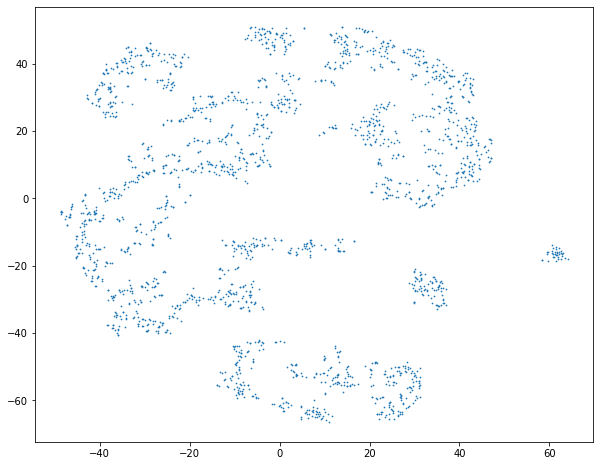

In [8]:
# create tsne object which will reduce data to 2 dimensions
plt.figure(figsize=(10, 8))

tsne = TSNE(n_components=2)
# apply t-SNE to data
data_2d = tsne.fit_transform(torch.flatten(latents, start_dim=1).cpu())
plt.scatter(data_2d[:,0], data_2d[:,1],s=0.5)

# visualise again and highlight actual classes of data

# colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple']

# for i in range(10):
#     plt.scatter(data_2d[labels.cpu() == i, 0], data_2d[labels.cpu() == i, 1], c=colours[i])
#     pass

# plt.legend()
plt.show()

### Clustering

In [42]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 16)
 
#predict the labels of clusters.
label = kmeans.fit_predict(torch.flatten(latents, start_dim=1).cpu())
 
print(len(label))

2140


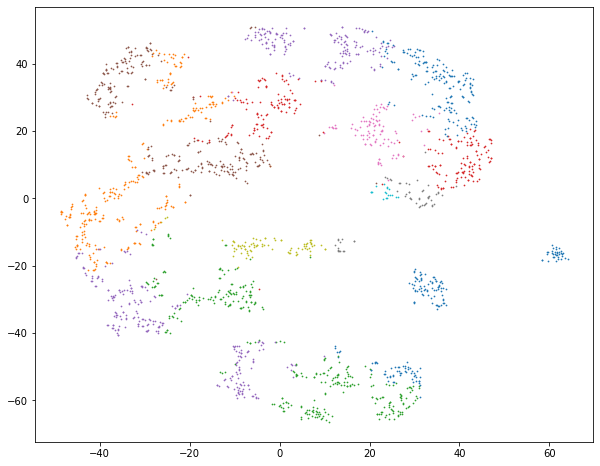

In [10]:
#Getting unique labels
plt.figure(figsize=(10, 8))

u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label = i, s=0.5)
# plt.legend()
plt.show()

# Visualize and Save Reconstruction Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


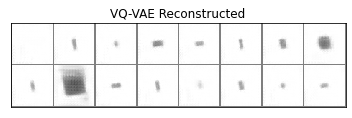

In [40]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(16, 64, 14, 14).astype('float32')).to(device)
vqae.eval()

valid_recon = vqae.decoder(latent_centers)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)

show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.savefig("VQrecon.png")

In [41]:
def rescale_img(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.Pad(56, fill=1.0)])
    return rescale(img)
rescaled_recon = rescale_img(valid_recon+0.5)

for i in range(rescaled_recon.shape[0]):
    save_image(rescaled_recon[i], f'../results/recon_img/img{i}.jpg')
    
print('save to results/recon_img/*.jpg')

save to results/recon_img/*.jpg


## For rhino mapping-back 

In [12]:
import glob
import cv2

In [27]:
valid_recon.shape

torch.Size([16, 1, 56, 56])

In [16]:
def show_and_save(img, filename):
    npimg = img.numpy()
    
    # get average pixel value that is not white
    # Get the average pixel value in the central 20x20 region
    npimg = img.numpy().squeeze()  # Remove the singleton dimensions
    # Get the dimensions of the image
    _, height, width = npimg.shape
    
    # Calculate the starting and ending indices for the central region
    start = (height - central_region_size) // 2
    end = start + central_region_size
    
    # Get the average pixel value in the central region for each channel
    central_region = npimg[:, start:end, start:end]
    average_pixel_value = np.mean(central_region, axis=(1, 2))
    
    # Draw a rectangle around the central region
    img_with_rectangle = np.copy(npimg)
    # img_with_rectangle[:, start:end, start:start+1] = 0  # Draw left vertical line
    # img_with_rectangle[:, start:end, end-1:end] = 0  # Draw right vertical line
    # img_with_rectangle[:, start:start+1, start:end] = 0  # Draw top horizontal line
    # img_with_rectangle[:, end-1:end, start:end] = 0 #  Draw bottom horizontal line
    
    # Resize image with rectangle to (224, 224)
    img_with_rectangle_resized = TF.resize(TF.to_pil_image(img_with_rectangle[0]), (224, 224))
    img_array = np.array(img_with_rectangle_resized)
    imageio.imwrite(filename, img_array)
    # title = str(average_pixel_value)
    # plt.imshow(np.transpose(img_with_rectangle, (1, 2, 0)), interpolation='nearest')
    # plt.axis('off')
    # #plt.title(title)
    # plt.savefig(filename, bbox_inches='tight')
    # plt.close()
    return average_pixel_value

central_region_size = 8
height_info = []
for i in range(valid_recon.shape[0]):
    reconstructed_img = valid_recon[i, 0, :, :]
    reconstructed_img_grid = torchvision.utils.make_grid(reconstructed_img.unsqueeze(0).cpu().data) + 0.5
    filename = f"../results/recon_img/reconstructed_{i+1}.png"  # Adjust the filename as per your preference
    average_pixel_value = show_and_save(reconstructed_img_grid, filename)
    height_info.append(average_pixel_value[0])

Lossy conversion from float32 to uint8. Range [0.9314517378807068, 1.0395591259002686]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.6211646199226379, 1.0415794849395752]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.6713264584541321, 1.035549521446228]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.5185083150863647, 1.0501652956008911]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.6444120407104492, 1.0339463949203491]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.6118228435516357, 1.0404905080795288]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.545336902141571, 1.031836867332458

In [17]:
height_info

[0.99939466,
 0.7638595,
 0.8480071,
 0.6178191,
 0.7671833,
 0.7883776,
 0.63107,
 0.49508572,
 0.81104016,
 0.3767733,
 0.74488246,
 0.79471254,
 0.9162681,
 0.7277682,
 0.8475752,
 0.8044999]

In [18]:
# Loop through each image
image_paths = glob.glob('recon_img/*.png')
lower_thres = 0.3
higher_thres = 0.7
for image_path in image_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    edges = cv2.Canny(gray, lower_thres, higher_thres)  # Adjust the threshold values as needed

    # Save the edge image
    filename = os.path.splitext(os.path.basename(image_path))[0]  # Extract the filename without extension
    edge_image_path = f'edge_img/{filename}_edge.jpg'
    cv2.imwrite(edge_image_path, edges)